In [17]:
# что происходит
# мы учим модель так, чтобы она училась на предыдущих наблюдениях,
# а результатом было бы не ЕДИНОЕ наблюдение, а ПОСЛЕДОВАТЕЛЬНОСТЬ
# мы учим модель делать ПОСЛЕДОВАТЕЛЬНОСТИ, после чего один раз просим спрогнозировать ПОСЛЕДОВАТЕЛЬНОСТЬ
# и мы получаем прогноз

In [18]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler, StandardScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

In [19]:
# download the data
df = yf.download(tickers=['AAPL'], period='1y')
y = df['Close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

[*********************100%%**********************]  1 of 1 completed
C:\Temp\ipykernel_6668\1950388798.py:3: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [20]:
# scale the data
# Ни в коем случае не использовать MinMaxScaler для прогноза временных рядов,
# так как цены волатильны и ограничивать рамками некорректно
# если будет выброс, то модель тут же сломается
# корректно использовать z-стандартизацию: средняя - 0, стандартное отклонение - 1
scaler = StandardScaler()

scaler = scaler.fit(y)
y = scaler.transform(y)

In [21]:
# generate the input and output sequences
n_lookback = 90  # length of input sequences (lookback period)
n_forecast = 60  # length of output sequences (forecast period)

In [22]:
X = []
Y = []

In [23]:
# если 90 на 60
# то мы идём от 90 до 252 - 60
# так как у нас lookback период 90, то мы можем взять 90 наблюдений только начиная с 90 строки в df
# а идем до 252 - 60, так как мы смотрим в будущее на 60 наблюдений
# то есть в таком случае мы учим модель 102 раза, чтобы в конце она нам предсказала 1 раз
for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])  # в x прибавляем, сколько мы смотрим назад
    Y.append(y[i: i + n_forecast])  # в y прибавляем, на сколько предсказываем вперёд

In [24]:
X = np.array(X)
Y = np.array(Y)

In [25]:
# fit the model
model = Sequential()
# на первом слое у нас n_lookback в качестве размерности, так как это и подаём внутрь
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
# в конце размерность n_forecast, то есть на выходе мы хотим получить ПОСЛЕДОВАТЕЛЬНОСТЬ
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=20, batch_size=32, verbose=0)

C:\Users\Влад\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [28]:
# теперь генерируем прогноз
# так как мы научили модель выдавать нам ПОСЛЕДОВАТЕЛЬНОСТЬ
# то теперь мы ей подаём последние n_lookback наблюдений и в качестве прогноза она нам и выдаст одну ПОСЛЕДОВАТЕЛЬНОСТЬ, что и является прогнозом
# на период n_forecast вперёд
X_ = y[- n_lookback:]
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)  # здесь результат

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


In [29]:
# organize the results in a data frame
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

In [30]:
df_future['Actual'] = df_future['Forecast']

In [31]:
visual = pd.concat([df_past, df_future])

In [32]:
import plotly.express as px

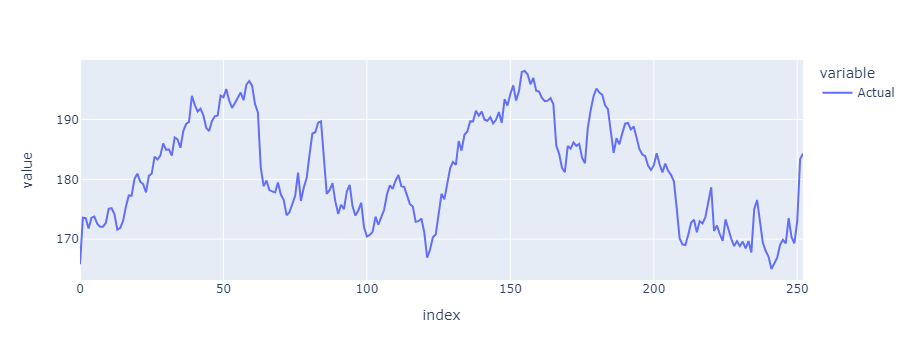

In [33]:
# последние n_forecast наблюдений и есть прогноз в будущее
px.line(visual.reset_index()['Actual'])